In [32]:
import gensim
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from matplotlib import pyplot as plt
import itertools
import seaborn as sns

In [33]:
file = "F:\PROJECT DSF\Fake_new_detction\glove.6B.50d.txt"
glove2word2vec(glove_input_file=file, word2vec_output_file="gensim_glove_vectors.txt")
 
###Finally, read the word2vec txt to a gensim model using KeyedVectors:
 
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [34]:
data_fake = pd.read_csv('F:\PROJECT DSF\Fake_new_detction\politifact_fake.csv')
data_real = pd.read_csv('F:\PROJECT DSF\Fake_new_detction\politifact_real.csv')

In [35]:
data_fake.head()

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [36]:
data_real.head()


,id,news_url,title,tweet_ids
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...


In [37]:
t=pd.DataFrame(data_real.title)
t['result']=0
r=pd.DataFrame(data_fake.title)
r['result']=1
s=t.append(r)
y1=s.dropna()
texts=y1['title']
y=y1['result']

In [38]:
y1

,title,result
0,National Federation of Independent Business,0
1,comments in Fayetteville NC,0
2,"Romney makes pitch, hoping to close deal : Ele...",0
3,Democratic Leaders Say House Democrats Are Uni...,0
4,"Budget of the United States Government, FY 2008",0
...,...,...
427,Who is affected by the government shutdown?,1
428,Lindsey Graham Threatens To Convert To Democra...,1
429,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,1
430,Sarah Palin Calls To Boycott Mall Of America B...,1


result
0    624
1    432
Name: title, dtype: int64


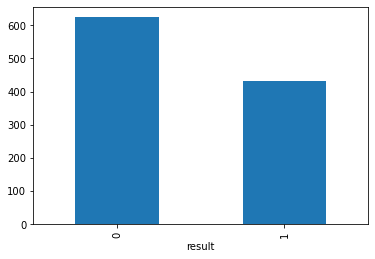

In [39]:
print(y1.groupby(['result'])['title'].count())
y1.groupby(['result'])['title'].count().plot(kind="bar")
plt.show()

In [40]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [41]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

In [42]:
corpus=[preprocess(text) for text in texts]

In [43]:
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus, texts and labels given the function condition_on_doc which takes
    a doc.
    The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, labels)

In [44]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [45]:
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

In [46]:
corpus, texts, y = filter_docs(corpus, texts, y, lambda doc: has_vector_representation(glove_model, doc))

15 docs removed


In [47]:
x =[]
for doc in corpus: #look up each doc in model
    x.append(document_vector(glove_model, doc))

In [48]:
#Apply Logistic regression

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [51]:
model = LogisticRegression()
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
Accuracy_LR=accuracy_score(y_test, y_pred)
F1_Score_LR=f1_score(y_test,y_pred)
print( "Accuracy_LR:",accuracy_score(y_test, y_pred))
print("F1_Score_LR:",f1_score(y_test,y_pred))

Accuracy_LR: 0.8306709265175719
F1_Score_LR: 0.7782426778242678


In [52]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


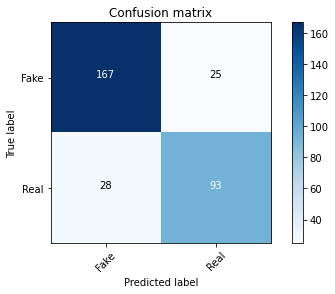

In [53]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [55]:
#Apply NaiveBases

In [56]:
from sklearn.naive_bayes import GaussianNB

In [57]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(x_test)
Accuracy_BAYES=accuracy_score(y_test, y_pred)
F1_Score_BAYES=f1_score(y_test,y_pred)
print("Accuracy_BAYES:",accuracy_score(y_test, y_pred))
print("F1_Score_BAYES:",f1_score(y_test,y_pred))

Accuracy_BAYES: 0.8115015974440895
F1_Score_BAYES: 0.7686274509803922


Confusion matrix, without normalization


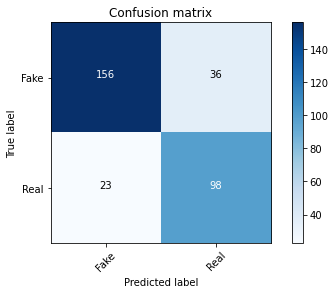

In [58]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [59]:
#Apply SVM

In [60]:
from sklearn.svm import SVC

In [61]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
Accuracy_SVM=accuracy_score(y_test, y_pred)
F1_Score_SVM=f1_score(y_test,y_pred)
print("Accuracy_SVM:",accuracy_score(y_test, y_pred))
print("F1_Score_SVM:",f1_score(y_test,y_pred))

Accuracy_SVM: 0.8210862619808307
F1_Score_SVM: 0.7647058823529412


Confusion matrix, without normalization


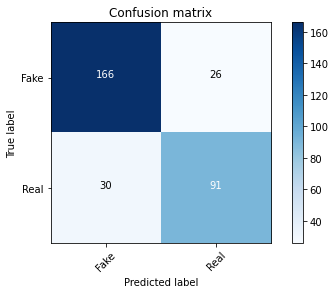

In [62]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [63]:
#Comparision:
print("MODELS\t\t\tACCURACY\t\tF1-SCORE")
print("____________________________________________________________")
print("LOGISTIC REGRESSION ", Accuracy_LR," ",F1_Score_LR)
print("____________________________________________________________")
print("Naive Baysian\t    ", Accuracy_BAYES," ",F1_Score_BAYES)
print("____________________________________________________________")
print("SVM\t\t    ", Accuracy_SVM," ",F1_Score_SVM)

MODELS			ACCURACY		F1-SCORE
____________________________________________________________
LOGISTIC REGRESSION  0.8306709265175719   0.7782426778242678
____________________________________________________________
Naive Baysian	     0.8115015974440895   0.7686274509803922
____________________________________________________________
SVM		     0.8210862619808307   0.7647058823529412
